In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
import itertools
from datasets import load_dataset
from sentence_transformers import SentenceTransformer , SentenceTransformerTrainer
from sentence_transformers.losses import CachedMultipleNegativesRankingLoss ,ContrastiveLoss, OnlineContrastiveLoss
import os
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
import torch
import functools
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Imports
import pandas as pd
from datasets import load_dataset , Dataset
from transformers import RobertaTokenizer , RobertaForSequenceClassification , TrainingArguments , Trainer,TrainerCallback,AutoModelForSequenceClassification,AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import torch
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
from datasets import Dataset, Features, Value,Sequence
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

def evaluate(y_true ,y_pred ): 
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)#, average='weighted'
    precision = precision_score(y_true, y_pred)#, average='weighted'
    recall = recall_score(y_true, y_pred)#, average='weighted'

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Calculate specificity (True Negative Rate)
    specificity = TN / (TN + FP)

    # Calculate NPV (Negative Predictive Value)
    NPV = TN / (TN + FN)

    auc = roc_auc_score(y_true, y_pred)

    results = {
        "F1 score": f1,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "Specificity": specificity,
        # "NPV": NPV
    }
    return results


In [ ]:
    
def SMILES_augmentation(df):
    smiles = df['SMILES'].to_list()
    randomize_func = functools.partial(randomize_smiles, random_type='restricted')
    to_smiles_func = get_smi_func('restricted')  
    randomized_smiles = list(map((lambda smi: to_smiles_func(randomize_func(Chem.MolFromSmiles(smi)))), smiles))
    randomized_smiles = pd.concat([pd.DataFrame(randomized_smiles, columns=['SMILES']), df.iloc[:,1:]], axis=1).dropna()
    augmented = pd.concat([df, randomized_smiles], axis=0).reset_index(drop=True)
    return augmented

def randomize_smiles(mol, random_type="restricted"):
    """
    Returns a random SMILES given a SMILES of a molecule.
    :param mol: A Mol object
    :param random_type: The type (unrestricted, restricted) of randomization performed.
    :return : A random SMILES string of the same molecule or None if the molecule is invalid.
    """
    if not mol:
        return None

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False)
    if random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        # random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=False)
    raise ValueError("Type '{}' is not valid".format(random_type))
    
def get_smi_func(smiles_type):
    """
    Returns a function pointer that converts a given SMILES string to SMILES of the given type.
    :param smiles_type: The SMILES type to convert VALUES=(deepsmiles.*, smiles, scaffold).
    :return : A function pointer.
    """
    if smiles_type.startswith("deepsmiles"):
        _, deepsmiles_type = smiles_type.split(".")
        return functools.partial(to_deepsmiles, converter=deepsmiles_type)
    elif smiles_type == "scaffold":
        return add_brackets_to_attachment_points
    else:
        return lambda x: x
    

In [ ]:
print("Imports completed")

os.environ["WANDB_DISABLED"] = "true"

df0 = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/DrugApp/All_training_feature_vectors.csv")
df=df0[["SMILES",	"Label"]]

print("dataset created ")

df.rename(columns={"Label":"labels"}, inplace=True)

test_size = 0.2
val_size = 0.5
train_df , temp = train_test_split(df , stratify = df.labels , test_size = test_size , random_state=1234)
test_df , val_df = train_test_split(temp , stratify = temp.labels , test_size = val_size , random_state=1234)
#-----------------------------------
# reset index
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Imports completed
dataset created 


/tmp/ipykernel_44787/706859662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Label":"labels"}, inplace=True)


In [ ]:
train_df = SMILES_augmentation(train_df)

In [ ]:
#-----------------------------------
# convert the dataframes to huggingface dataset for easier upload on hub and eaiser accessibility
dataset_train = Dataset.from_pandas(train_df)
dataset_df = Dataset.from_pandas(val_df)
dataset_test = Dataset.from_pandas(test_df)
#tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")#'FacebookAI/xlm-roberta-large'
tokenizer = RobertaTokenizer.from_pretrained("/home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca")#'FacebookAI/xlm-roberta-large'


def tokenize_function(examples):
    return tokenizer(examples['SMILES'], padding="max_length" , truncation=True )#,max_length=166

tokenized_train = dataset_train.map(tokenize_function)
tokenized_val = dataset_df.map(tokenize_function)
tokenized_test = dataset_test.map(tokenize_function)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([len(train_df[train_df["labels"] == i]) / len(train_df) for i in np.unique(train_df["labels"])]).to(device)
#class_weights = torch.tensor([0.25,0.25,0.25,0.25]).to(device)

class CustomLoss(nn.Module):
    def __init__(self, class_weights):
        super(CustomLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, labels):
        ce_loss = self.ce_loss(logits, labels)
        l1_loss = torch.mean(torch.abs(logits))
        return ce_loss + 0.01 * l1_loss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = CustomLoss(class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss
    


model = RobertaForSequenceClassification.from_pretrained("/home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca" ,num_labels=2)
model.config.classifier_dropout=0.01

os.environ["WANDB_DISABLED"] = "true"

Map:   0%|          | 0/4994 [00:00<?, ? examples/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import EarlyStoppingCallback
training_args = TrainingArguments(
    output_dir='/home/u111169/wrkdir/mgh-project/arxive/checkpoints-arxive/fine_tuning_chemberta_classic_way/augmented',
    num_train_epochs= 15,
    evaluation_strategy='steps',
    save_strategy='steps',
    learning_rate=2e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    eval_steps=20,
    #save_total_limit=3,
    gradient_accumulation_steps=1,
    eval_accumulation_steps=1,
    do_eval=True,
    do_train=True,
    weight_decay=0.1,
    #logging_dir = "logs",
    logging_strategy="steps",
    logging_steps = 10,
    dataloader_drop_last=True,
    save_safetensors=False,
    adam_epsilon=1e-08,
    warmup_steps=100,
    seed=42,
    lr_scheduler_type='cosine',
    load_best_model_at_end = True,
    label_smoothing_factor=0.01,
)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer = tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

/home/u111169/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.3.18, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [23]:
trainer.train()

Step,Training Loss,Validation Loss
20,0.604700,0.534256
40,0.519600,0.509695
60,0.567300,0.484785
80,0.530100,0.494512
100,0.485000,0.564889
120,0.531800,0.496324
140,0.503700,0.503806
160,0.542300,0.526010
180,0.510500,0.485058
200,0.469500,0.557577


TrainOutput(global_step=660, training_loss=0.44506994594227184, metrics={'train_runtime': 141.1205, 'train_samples_per_second': 530.823, 'train_steps_per_second': 8.291, 'total_flos': 389240499732480.0, 'train_loss': 0.44506994594227184, 'epoch': 8.461538461538462})

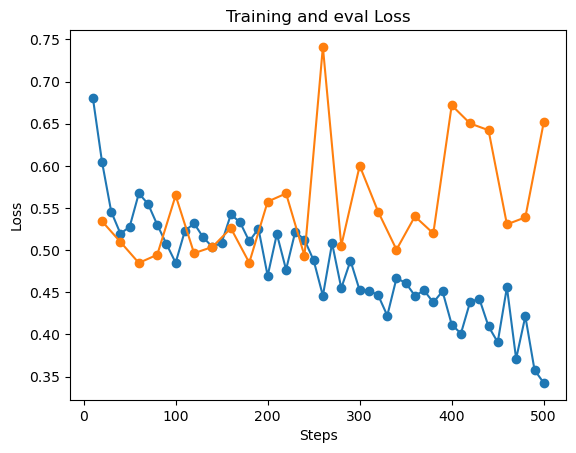

In [24]:
# Drawing the loss plot

import json
import matplotlib.pyplot as plt

# Step 1: Open and load the JSON file
with open("/home/u111169/wrkdir/mgh-project/arxive/checkpoints-arxive/fine_tuning_chemberta_classic_way/augmented/checkpoint-500/trainer_state.json", "r") as json_file:
    json_data = json.load(json_file)

data = json_data["log_history"]



# Extract steps and losses from the data
steps = [entry["step"] for entry in data if "step" in entry and "loss" in entry]
steps_ev = [step for step in steps if step % 20 == 0]
losses_t = [entry["loss"] for entry in data if "step" in entry and "loss" in entry]
losses_e = [entry["eval_loss"] for entry in data if "step" in entry and "eval_loss" in entry]
# Create a line plot
plt.plot(steps, losses_t, marker="o")
plt.plot(steps_ev, losses_e, marker="o")

# Set labels and title
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and eval Loss")

plt.savefig("plot.png", bbox_inches="tight")
# Display the plot
plt.show()

In [ ]:
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("/home/u111169/wrkdir/mgh-project/arxive/checkpoints-arxive/fine_tuning_chemberta_classic_way/augmented/checkpoint-500" ,num_labels=2)
model.to(device)
model.eval()

def preprocess_and_predict(examples):
    inputs = tokenizer(examples['SMILES'], return_tensors='pt', padding=True, truncation = True)
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted_class_idx = torch.argmax(outputs.logits)
    predicted_class_prob = torch.nn.functional.softmax(outputs.logits, dim=1)[0][predicted_class_idx]
    predicted_class_idx = predicted_class_idx.cpu()  # Move tensors to CPU
    predicted_class_prob = predicted_class_prob.cpu()
    return {
        'predicted_class': predicted_class_idx,
        'predicted_class_prob': predicted_class_prob
    }

test = tokenized_test.map(preprocess_and_predict, batch_size=8 , writer_batch_size=8)
results_df = test.to_pandas()
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score

y_true = results_df['labels'].tolist()
y_pred = results_df['predicted_class'].tolist()


Map:   0%|          | 0/312 [00:00<?, ? examples/s]

In [ ]:
evaluate(y_true ,y_pred )

{'F1 score': 0.7164948453608248,
 'Accuracy': 0.6474358974358975,
 'Precision': 0.7354497354497355,
 'Recall': 0.6984924623115578,
 'AUC': 0.6280072931026816,
 'Specificity': 0.5575221238938053}